<a href="https://colab.research.google.com/github/msa1997/Prompt-Tuning/blob/main/t5_prompt_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-tuning T5 with Soft Prompts for Sentiment Classification.**

 *  This version initializes the soft prompt with a specific sentence.
 *  The model is T5ForConditionalGeneration.
 *  The dataset is stanfordnlp/imdb.



# Library

**Installing required library:**

In [ ]:
!pip install datasets transformers torch tqdm matplotlib seaborn wandb

**Import all the needed library:**

In [ ]:
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset, ClassLabel
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

#Config

In [ ]:
# Configuration class
class Config:
    def __init__(self):
        self.model_name = "t5-small"
        self.dataset_name = "imdb"
        self.prompt_text = "Is the sentiment of this review positive or negative?"  # Initial prompt text
        self.max_len = 256
        self.train_batch = 32
        self.valid_batch = 32
        self.epochs = 3
        self.learning_rate = 1e-1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name)
        self.n_tokens = len(self.tokenizer(self.prompt_text)["input_ids"]) # Calculate n_tokens based on prompt


CONFIG = Config()

#Dataset

In [ ]:
# Load dataset
dataset = load_dataset(CONFIG.dataset_name)

# Define label mapping dictionary
label_mapping = {0: "negative", 1: "positive"}

if CONFIG.dataset_name == 'imdb':
    train_dataset = dataset["train"].shuffle().select(range(5000))  # Sample for testing
    validation_dataset = dataset["test"].shuffle().select(range(2000))  # Sample for testing
    #train_dataset = dataset["train"] # Sample for testing
    #validation_dataset = dataset["test"]  # Sample for testing

    # Create a new `string_label` column based on the integer `label`
    def preprocess_imdb(examples):
        return {
            'text': examples['text'],
            'string_label': label_mapping[examples['label']]
        }

    # Apply the mapping to add `string_label` column without altering the existing `label` column
    train_dataset = train_dataset.map(preprocess_imdb)
    validation_dataset = validation_dataset.map(preprocess_imdb)



Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


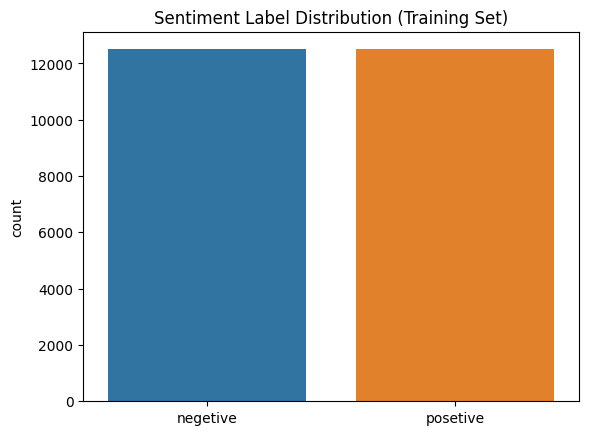

In [ ]:
# EDA - Distribution of sentiment labels
sns.countplot(x=['posetive' if i==1 else 'negetive' for i in dataset['train']['label']])
plt.title('Sentiment Label Distribution (Training Set)')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


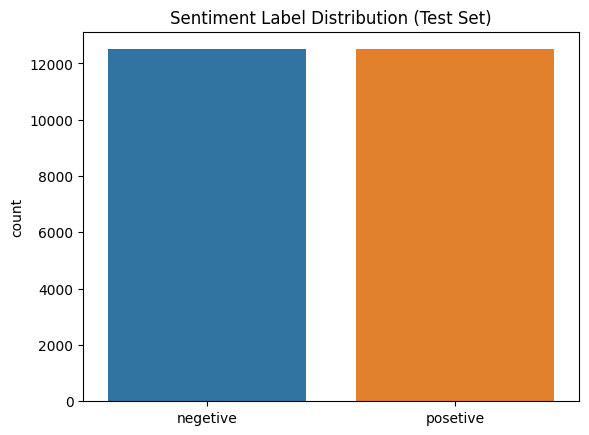

In [ ]:
# EDA - Distribution of sentiment labels
sns.countplot(x=['posetive' if i==1 else 'negetive' for i in dataset['test']['label']])
plt.title('Sentiment Label Distribution (Test Set)')
plt.show()


## Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, n_tokens, initial_prompt_ids, device):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.n_tokens = n_tokens
        self.initial_prompt_ids = initial_prompt_ids.to(device) # Moved to device here!
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data['text'][index])  # Ensure text is a string
        label = str(self.data['string_label'][index])  # Ensure label is a string

        # Tokenize input text
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len - self.n_tokens, # Account for prompt length
            padding='max_length',
            return_tensors='pt',
        )

        # Tokenize label
        labels = self.tokenizer(
            label,
            max_length=2,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )["input_ids"].squeeze(0).to(CONFIG.device)



        inputs = {k: v.squeeze(0).to(CONFIG.device) for k, v in inputs.items()}

        # Concatenate - all tensors are now on the correct device
        inputs['input_ids'] = torch.cat([self.initial_prompt_ids, inputs['input_ids']], dim=0).to(CONFIG.device)

        inputs['attention_mask'] = torch.cat([torch.ones_like(self.initial_prompt_ids), inputs['attention_mask']], dim=0).to(CONFIG.device)
        return {  # No need to move to device here anymore
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': labels  # 'labels' was already on the device
        }


In [ ]:
# Tokenize the initial prompt
initial_prompt_ids = CONFIG.tokenizer(CONFIG.prompt_text, return_tensors="pt")["input_ids"].squeeze(0).to(CONFIG.device)



In [ ]:
# Create datasets, passing the device
train_dataset_pt = CustomDataset(train_dataset, CONFIG.tokenizer, CONFIG.max_len, CONFIG.n_tokens, initial_prompt_ids, CONFIG.device)
validation_dataset_pt = CustomDataset(validation_dataset, CONFIG.tokenizer, CONFIG.max_len, CONFIG.n_tokens, initial_prompt_ids, CONFIG.device)

#Soft Prompt layer

**Explanation of Prompt Tuning:**

Prompt tuning is a parameter-efficient fine-tuning technique where instead of fine-tuning the entire pre-trained language model (PLM), a small set of learnable parameters, called "soft prompts" or "prompt embeddings", are introduced.  These soft prompts are prepended to the input text embeddings and learned during training, while the PLM's weights remain frozen. This approach has shown comparable performance to full fine-tuning with significantly fewer trainable parameters.

**How it works:**

1. **Initialization:** The soft prompt is initialized, often randomly or with task-specific information. In this code, it's initialized with the embedding of a specific prompt sentence.
2. **Concatenation:** The soft prompt embeddings are concatenated with the input text embeddings.
3. **Frozen PLM:**  The PLM's weights are frozen, and only the soft prompt embeddings are updated during training via backpropagation.
4. **Inference:** During inference, the learned prompt is prepended to the input text, allowing the PLM to perform the task without any modification to its internal weights.


In [ ]:
class SoftPromptEmbedding(nn.Module):
    def __init__(self, original_embedding, initial_prompt_embeddings):
        super().__init__()
        # Create a Parameter from a copy to ensure gradients are tracked
        self.prompt_embedding = nn.Parameter(initial_prompt_embeddings.clone().float())  # .clone().float() is key
        self.n_tokens = self.prompt_embedding.shape[0]

    def forward(self, input_ids):
        prompt_embeddings = self.prompt_embedding.unsqueeze(0).expand(input_ids.shape[0], -1, -1).to(CONFIG.device) # expand to batch size

        # original input embeddings after prompt
        input_embeddings = original_embedding(input_ids[:, self.n_tokens:]).to(CONFIG.device)
        combined_embeddings = torch.cat([prompt_embeddings, input_embeddings], dim=1)
        return combined_embeddings

#Model

In [ ]:
# Model initialization
model = T5ForConditionalGeneration.from_pretrained(CONFIG.model_name).to(CONFIG.device)
original_embedding = model.get_encoder().get_input_embeddings()
initial_prompt_embeddings = model.get_encoder().get_input_embeddings()(initial_prompt_ids)
# Create soft prompt embedding layer
soft_prompt_embedding = SoftPromptEmbedding(original_embedding, initial_prompt_embeddings).to(CONFIG.device)
model.get_encoder().set_input_embeddings(soft_prompt_embedding)


**Check model architecture:**

In [ ]:
# Print model architecture
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): SoftPromptEmbedding()
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## Freeze parameters (excluding the soft prompt embeddings)

In [ ]:
# Freeze parameters (excluding the soft prompt embeddings)
for name, param in model.named_parameters():
    if "prompt_embedding" not in name:
        param.requires_grad = False

**Explanation of Freezing Layers:**

Freezing layers means preventing their weights from being updated during training. This is a common technique in transfer learning to leverage the knowledge captured in a pre-trained model while adapting it to a new task.  By freezing most of the PLM and only training the soft prompt, we reduce the risk of catastrophic forgetting (where the model forgets its pre-trained knowledge) and improve training efficiency.

**Check Freeze parameters:**

In [ ]:
# Analyze parameters
total_params = 0
trainable_params = 0
non_trainable_params = 0

for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        print(f"Trainable: {name}, Shape: {param.shape}, Num Params: {param.numel()}")
    else:
        non_trainable_params += param.numel()
        print(f"Non-Trainable: {name}, Shape: {param.shape}, Num Params: {param.numel()}")



Non-Trainable: shared.weight, Shape: torch.Size([32128, 512]), Num Params: 16449536
Trainable: encoder.embed_tokens.prompt_embedding, Shape: torch.Size([12, 512]), Num Params: 6144
Non-Trainable: encoder.block.0.layer.0.SelfAttention.q.weight, Shape: torch.Size([512, 512]), Num Params: 262144
Non-Trainable: encoder.block.0.layer.0.SelfAttention.k.weight, Shape: torch.Size([512, 512]), Num Params: 262144
Non-Trainable: encoder.block.0.layer.0.SelfAttention.v.weight, Shape: torch.Size([512, 512]), Num Params: 262144
Non-Trainable: encoder.block.0.layer.0.SelfAttention.o.weight, Shape: torch.Size([512, 512]), Num Params: 262144
Non-Trainable: encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight, Shape: torch.Size([32, 8]), Num Params: 256
Non-Trainable: encoder.block.0.layer.0.layer_norm.weight, Shape: torch.Size([512]), Num Params: 512
Non-Trainable: encoder.block.0.layer.1.DenseReluDense.wi.weight, Shape: torch.Size([2048, 512]), Num Params: 1048576
Non-Trainable: encode

In [ ]:
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 60512768
Trainable parameters: 6144
Non-trainable parameters: 60506624


**Set optimizer for soft prompt embeding:**

In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CONFIG.learning_rate)


#Train

In [ ]:
# Data Loaders
train_loader = DataLoader(train_dataset_pt, batch_size=CONFIG.train_batch, shuffle=True)
validation_loader = DataLoader(validation_dataset_pt, batch_size=CONFIG.valid_batch, shuffle=False)

In [ ]:
class Trainer:
    def __init__(self, model, tokenizer, train_dataset, val_dataset, config):
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.config = config

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.config.train_batch, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.config.valid_batch, shuffle=False)

        self.optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.config.learning_rate)

        self.train_losses = []
        self.currenct_epoch = 0


    def train(self):
        for epoch in range(self.config.epochs):
            self.currenct_epoch += 1
            self.model.train()
            total_loss = 0

            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch + 1}"):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)

                self.optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                loss.backward()
                self.optimizer.step()

            avg_loss = total_loss / len(self.train_loader)
            self.train_losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{self.config.epochs} - Average training loss: {avg_loss:.4f}")


    def evaluate(self):
        self.model.eval()
        correct_predictions_direct = 0
        correct_predictions_prob = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)  # Get the labels from the batch
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                generated_outputs = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=2)

                for i in range(len(labels)):
                    predicted_label = self.config.tokenizer.decode(generated_outputs[i], skip_special_tokens=True).lower()
                    true_label = self.config.tokenizer.decode(labels[i], skip_special_tokens=True).lower()

                    if predicted_label == true_label:
                        correct_predictions_direct += 1

                    # Get the vocabulary indices of "negative" and "positive"
                    neg_token_id = self.config.tokenizer.encode("negative")[0]
                    pos_token_id = self.config.tokenizer.encode("positive")[0]


                    # Get probabilities for "negative" and "positive" from the logits
                    neg_prob = torch.softmax(logits[i, 0, :], dim=-1)[neg_token_id].item()
                    pos_prob = torch.softmax(logits[i, 0, :], dim=-1)[pos_token_id].item()


                    prob_based_prediction = "negative" if neg_prob > pos_prob else "positive"
                    if prob_based_prediction == true_label:
                        correct_predictions_prob += 1

                    total_predictions += 1

        accuracy_direct = correct_predictions_direct / total_predictions
        accuracy_prob = correct_predictions_prob / total_predictions

        print(f"Direct Comparison Accuracy: {accuracy_direct:.4f}")
        print(f"Probability-based Accuracy: {accuracy_prob:.4f}")

        self.model.train()
        return {"val_accuracy_direct": accuracy_direct, "val_accuracy_prob": accuracy_prob}

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.show()


In [ ]:

# Create Trainer instance
trainer = Trainer(model, CONFIG.tokenizer, train_dataset_pt, validation_dataset_pt, CONFIG)

In [ ]:
#Evaluate
before_train = trainer.evaluate()

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Direct Comparison Accuracy: 0.0000
Probability-based Accuracy: 0.7315


In [ ]:
#train
trainer.train()

Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3 - Average training loss: 5.3597


Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3 - Average training loss: 0.3346


Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3 - Average training loss: 0.2872


In [ ]:
#Evaluate
after_train = trainer.evaluate()

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Direct Comparison Accuracy: 0.8315
Probability-based Accuracy: 0.8315


#Resault

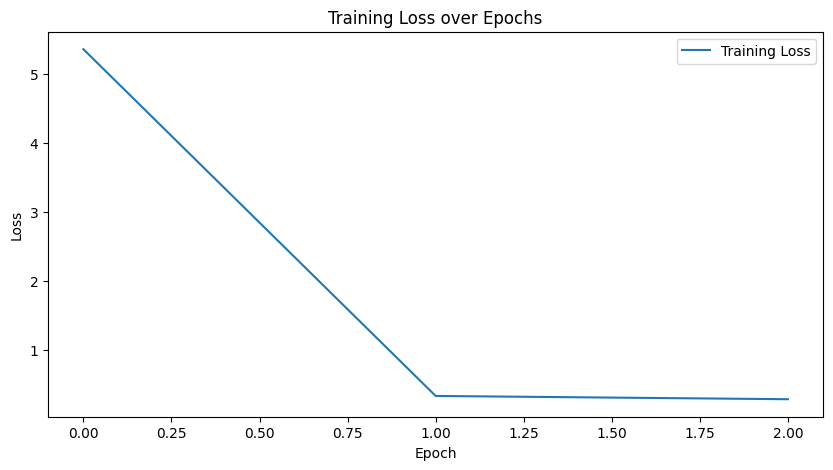

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(trainer.train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()


## Training losses

In [ ]:
trainer.plot

<bound method Trainer.plot of <__main__.Trainer object at 0x7e379ce55870>>

## compair result before and after training

**Direct Comparison Accuracy:**


This metric directly compares the entire generated output token sequence against the gold standard label sequence. It counts a prediction as correct only if the generated sequence exactly matches the true label sequence. This method is stricter and more sensitive to variations in the generated output.

In [ ]:
print(f'''Before training accuracy was: {before_train['val_accuracy_direct']} \n after Training accuracy is: {after_train['val_accuracy_direct']}''')

Before training accuracy was: 0.0 
 after Training accuracy is: 0.8315


**Probability-based Accuracy:**

 This metric examines the first generated token's logits and calculates the probabilities specifically for the 'positive' and 'negative' tokens. It then compares these two probabilities. The label corresponding to the higher probability is chosen as the model's prediction. This approach can be more robust than direct comparison because it focuses on the model's confidence in the relevant labels, even if other tokens are generated.



In [ ]:
print(f'''Before training accuracy was: {before_train['val_accuracy_prob']} \n after Training accuracy is: {after_train['val_accuracy_prob']}''')

Before training accuracy was: 0.7315 
 after Training accuracy is: 0.8315


## test model manual

In [ ]:
review = '''
the movie was good
'''
inputs = CONFIG.tokenizer(
    review,
    truncation=True,
    max_length=CONFIG.max_len - CONFIG.n_tokens,
    padding='max_length',
    return_tensors='pt',
)

# Keep the batch dimension
inputs = {k: v.to(CONFIG.device) for k, v in inputs.items()}


inputs['input_ids'] = torch.cat([initial_prompt_ids.unsqueeze(0), inputs['input_ids']], dim=1).to(CONFIG.device) # Add batch dim to prompt ids
inputs['attention_mask'] = torch.cat([torch.ones_like(initial_prompt_ids).unsqueeze(0), inputs['attention_mask']], dim=1).to(CONFIG.device)



model.eval() # Set the model to evaluation mode. VERY IMPORTANT, it affects the output.

generated_outputs = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_new_tokens=10  # Adjust max_new_tokens as needed
)

print(CONFIG.tokenizer.decode(generated_outputs[0], skip_special_tokens=True))

positive


In [ ]:
review = '''
the movie was bad
'''
inputs = CONFIG.tokenizer(
    review,
    truncation=True,
    max_length=CONFIG.max_len - CONFIG.n_tokens,
    padding='max_length',
    return_tensors='pt',
)

# Keep the batch dimension
inputs = {k: v.to(CONFIG.device) for k, v in inputs.items()}


inputs['input_ids'] = torch.cat([initial_prompt_ids.unsqueeze(0), inputs['input_ids']], dim=1).to(CONFIG.device) # Add batch dim to prompt ids
inputs['attention_mask'] = torch.cat([torch.ones_like(initial_prompt_ids).unsqueeze(0), inputs['attention_mask']], dim=1).to(CONFIG.device)



model.eval() # Set the model to evaluation mode. VERY IMPORTANT, it affects the output.

generated_outputs = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_new_tokens=10  # Adjust max_new_tokens as needed
)

print(CONFIG.tokenizer.decode(generated_outputs[0], skip_special_tokens=True))

negative
